# Lecture 4: K-Nearest Neighbors and Support Vector Machines

Resources: 
- https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote09.html
- https://web.mit.edu/6.034/wwwbob/svm.pdf

## K-Nearest Neighbors

K-Nearest Neighbors is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions). An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True, as_frame=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [2]:
y.value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

In [3]:
# sort the data by target values
df = X.join(y).sort_values(by='target')
X, y = df.drop(columns='target'), df['target']
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
32,13.68,1.83,2.36,17.2,104.0,2.42,2.69,0.42,1.97,3.84,1.23,2.87,990.0
33,13.76,1.53,2.70,19.5,132.0,2.95,2.74,0.50,1.35,5.40,1.25,3.00,1235.0
34,13.51,1.80,2.65,19.0,110.0,2.35,2.53,0.29,1.54,4.20,1.10,2.87,1095.0
35,13.48,1.81,2.41,20.5,100.0,2.70,2.98,0.26,1.86,5.10,1.04,3.47,920.0


In [4]:
splits = y.diff().values.nonzero()[0]
splits

array([  0,  59, 130], dtype=int64)

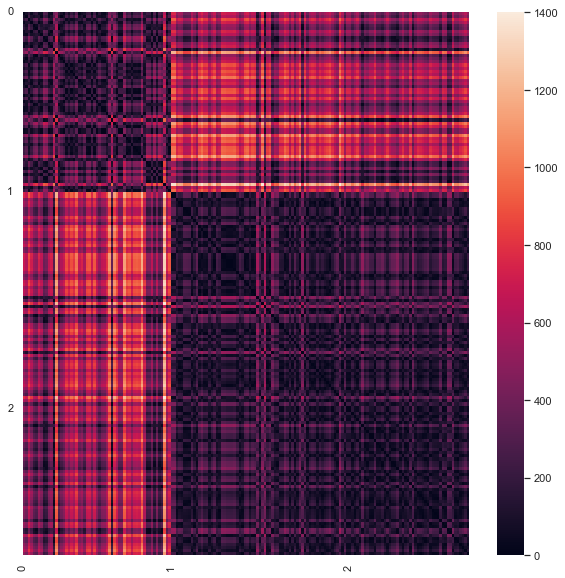

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

sns.set()

dist_mat = pairwise_distances(X, metric='euclidean')
plt.figure(figsize=(10, 10))
sns.heatmap(dist_mat)
plt.xticks(splits, y[splits].values)
plt.yticks(splits, y[splits].values)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
dist_mat_test = pairwise_distances(X_test, X_train, metric='euclidean')
print(dist_mat_test.shape)
K = 3
neighbors = np.argsort(dist_mat_test, axis=1)[:, :K]
neighbors[:5]

(36, 142)


array([[ 49, 103,  86],
       [ 44,  16, 121],
       [ 25,  69, 131],
       [ 32, 139,  77],
       [140,  73, 134]], dtype=int64)

In [8]:
y_train

132    2
155    2
71     1
133    2
8      0
      ..
111    1
62     1
44     0
113    1
67     1
Name: target, Length: 142, dtype: int32

In [9]:
y_train.loc[[132, 155, 71]]

132    2
155    2
71     1
Name: target, dtype: int32

In [10]:
y_train.iloc[neighbors[0]]

57    0
49    0
27    0
Name: target, dtype: int32

In [11]:
prediction = np.array([y_train.iloc[nbs].mode().values[0] 
                       for nbs in neighbors])
prediction

array([0, 0, 1, 0, 1, 0, 1, 2, 2, 2, 0, 2, 0, 1, 0, 0, 1, 1, 0, 2, 0, 2,
       1, 0, 1, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 0])

In [12]:
accuracy_score(y_test, prediction)

0.6944444444444444

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=K)
knn.fit(X_train, y_train)
accuracy_score(y_test, knn.predict(X_test))

0.6944444444444444

In practice, KNN has both low efficiency and low accuracy. However, it can be used as a baseline algorithm to compare with other more sophisticated algorithms. In addition, the concept of KNN is very important in machine learning. It is the basis of many other popular algorithms, such as K-means and support vector machine.

### Non-Parametric Models

A parametric model $f_\theta$ assumes that the data can be well approximated by a fixed set of parameters $\theta$. For example, a linear regression model uses a vector of weights and a bias to approximate the data. In contrast, a non-parametric model does not make any assumption on the functional form of the data. Instead, it **stores** the training data and uses it to make predictions. Decision tree, random forest, KNN are all non-parametric models. Next we are going to introduce another non-parametric model, support vector machine.

## Support Vector Machines

How to use a linear model for classification?

In [110]:
from sklearn.datasets import make_blobs
import plotly.express as px
import plotly.graph_objects as go

X, y = make_blobs(n_samples=100, centers=[[-1, -1], [1, 1]],
                  random_state=1, cluster_std=0.5)
y = np.where(y == 0, -1, 1)

# add an interactive classification line
a = np.linspace(-np.pi/2, np.pi/2, 100)
points = []
for ai in a:
    x00, x01 = -5 * np.cos(ai), 5 * np.cos(ai)
    x10, x11 = -5 * np.sin(ai), 5 * np.sin(ai)
    wi = np.tan(ai)
    points.append([x00, x10, wi])
    points.append([x01, x11, wi])

clf_line = pd.DataFrame(points, columns=['x0', 'x1', 'w'])
fig = px.line(clf_line, x='x0', y='x1', animation_frame='w',
              color_discrete_sequence=px.colors.qualitative.Alphabet,
              width=600, height=600, range_x=[-3, 3], range_y=[-3, 3])

# plot the data points
df = pd.DataFrame(X, columns=['x0', 'x1']).join(
    pd.Series(y, name='target'))
fig.add_traces(px.scatter(df, x='x0', y='x1', color=y.astype(str)).data)

fig.layout.pop('updatemenus')
fig

### Margin

For a linear model $f_w(x) = w^Tx + b$, the distance from a point $x$ to the decision boundary $f_w=0$ is given by $$\frac{|w^Tx + b|}{\|w\|}.$$
A dataset $\mathcal{D} = \{(x_1, y_1), \ldots, (x_n, y_n)\}$, $x_i\in\mathbb{R^m}$, $y_i\in\{-1,1\}$,  is **linearly separable** if there exists a linear model $f_w$ such that $f_w(x_i) \ge 0$ for all $i$ with $y_i = 1$ and $f_w(x_i) \le 0$ for all $i$ with $y_i = -1$.
In this case, the distance from $x$ to $f_w=0$ can be written as $$\frac{y(w^Tx + b)}{\|w\|}.$$
The minimum distance from any point $x$ to the decision boundary is called the **margin**: $$\min_{x \in \mathcal{D}} \frac{y(w^Tx + b)}{\|w\|}.$$ 

In [111]:
def point_line_dist(x0, x1, y, w):
    return y * (-w * x0 + x1) / np.sqrt(1 + w**2)

def find_support_vectors(X, y, w):
    # find the support vectors
    dists = point_line_dist(X[:, 0], X[:, 1], y, w)
    s = np.argmin(dists)
    return X[s], dists[s]

find_support_vectors(df[['x0', 'x1']].values, df['target'].values, w=-1.0)

(array([ 0.84494161, -0.21741888]), 0.4437255785713139)

In [112]:
# min distance < 0: not linearly separable
# check this with the plot above!
find_support_vectors(df[['x0', 'x1']].values, df['target'].values, w=0.0)

(array([ 0.84494161, -0.21741888]), -0.2174188820535694)

### Maximum Margin Classifier

In [113]:
ws = clf_line.w.unique()  # get the unique values of w
res = max(
    [dict(supvec=v, mindist=d, weight=w)
     for w in ws
     for v, d in [find_support_vectors(
         df[['x0', 'x1']].values, df['target'].values, w)]],
    key=lambda dct: dct['mindist'])  # key is a function for which the max is taken
res

{'supvec': array([-0.43418531, -0.24009159]),
 'mindist': 0.49377457413347914,
 'weight': -1.452539024396838}

In [114]:
supvec = res['supvec']
optimal_w = res['weight']

def margin_lines(x, y, w):
    x0 = -5
    x1 = 5
    b = -w * x + y
    xs = np.array([x0, x1])
    for b_ in [-b, b]:
        ys = w * xs + b_
        yield np.array([xs, ys, [w, w]]).T

margin1, margin2 = margin_lines(*supvec, optimal_w)
df1 = pd.DataFrame(margin1, columns=['x0', 'x1', 'w'])
df2 = pd.DataFrame(margin2, columns=['x0', 'x1', 'w'])

fig = px.scatter(df, x='x0', y='x1', color=y.astype(str),
                 width=600, height=600, range_x=[-3, 3], range_y=[-3, 3])
fig.add_traces(px.line(clf_line[clf_line.w == optimal_w], x='x0', y='x1',
                       color_discrete_sequence=px.colors.qualitative.Alphabet).data)
fig.add_traces(px.line(df1, x='x0', y='x1',
                       color_discrete_sequence=px.colors.qualitative.Pastel).data)
fig.add_traces(px.line(df2, x='x0', y='x1',
                       color_discrete_sequence=px.colors.qualitative.Pastel).data)

fig

### Soft Margin

What if the dataset is not perfectly linearly separable? We still want to find a linear model that separates the data as well as possible. We can allow some data points to be on the wrong side of the decision boundary.

The loss function is now defined as $$L(w, b) = \sum_{i=1}^n \max(0, 1 - y_i(w^Tx_i + b)) + \lambda \|w\|^2,$$ where $\lambda$ is a hyperparameter that controls the trade-off between the margin and the loss. 

In [20]:
from sklearn.datasets import make_blobs
import plotly.express as px

X, y = make_blobs(n_samples=100, centers=[[-1, -1], [1, 1]],
                  random_state=1, cluster_std=1.)
y = np.where(y == 0, -1, 1)

df = pd.DataFrame(X, columns=['x0', 'x1']).join(
    pd.Series(y, name='target'))

fig = px.scatter(df, x='x0', y='x1', color=y.astype(str),
                 width=600, height=600, range_x=[-3, 3], range_y=[-3, 3])

fig

In [21]:
from sklearn.svm import SVC, LinearSVC

lin_svc = LinearSVC(C=1, random_state=42)
lin_svc.fit(X, y)
lin_svc.coef_, lin_svc.intercept_

(array([[1.1664128 , 0.83119657]]), array([-0.22276584]))

In [22]:
xlim = np.array([-5, 5])
(w0, w1), b = lin_svc.coef_[0], lin_svc.intercept_[0]
ylim = -w0/w1 * xlim - b/w1
fig.add_traces(px.line(x=xlim, y=ylim).data)

### Feature Maps

C:\Users\13818\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



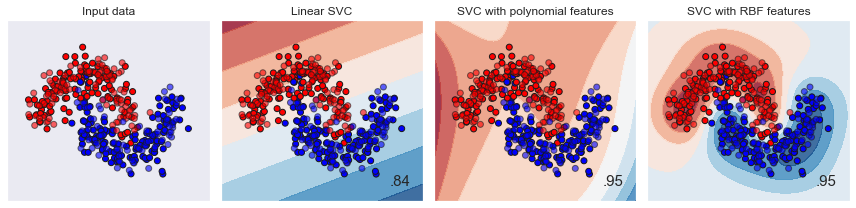

In [24]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.kernel_approximation import Nystroem

from sklearn.datasets import make_moons
from sklearn.pipeline import make_pipeline
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

X, y = make_moons(noise=0.2, random_state=0, n_samples=400)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# create feature maps
poly = PolynomialFeatures(degree=4)
rbf = Nystroem(gamma=1, n_components=100)

classifiers = {
    'Linear SVC':
        LinearSVC(C=1, random_state=42),
    'SVC with polynomial features':
        make_pipeline(poly, LinearSVC(C=1, random_state=42)),
    'SVC with RBF features':
        make_pipeline(rbf, LinearSVC(C=1, random_state=42)),
}

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

plt.figure(figsize=(3 * (len(classifiers) + 1), 3))

i = 1
ax = plt.subplot(1, len(classifiers) + 1, i)

ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
# Plot the testing points
ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in classifiers.items():
    ax = plt.subplot(1, len(classifiers) + 1, i)

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    DecisionBoundaryDisplay.from_estimator(
        clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
    )

    # Plot the training points
    ax.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
    )
    # Plot the testing points
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )
    i += 1

plt.tight_layout()
plt.show()

## Regressions

In [49]:
from sklearn.datasets import fetch_california_housing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15480 entries, 8158 to 15795
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      15480 non-null  float64
 1   HouseAge    15480 non-null  float64
 2   AveRooms    15480 non-null  float64
 3   AveBedrms   15480 non-null  float64
 4   Population  15480 non-null  float64
 5   AveOccup    15480 non-null  float64
 6   Latitude    15480 non-null  float64
 7   Longitude   15480 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### KNN Regression

In [28]:
from sklearn.metrics import r2_score

r2_score(y_test, KNeighborsRegressor().fit(X_train, y_train).predict(X_test))

0.14434206676911643

### Standard Scaling

Shift and scale the data so that it has zero mean and unit variance. This is useful for algorithms (KNN, SVM, etc.) that assume that all features are centered around zero and have approximately the same variance.

Compare with the performance before standard scaling!

In [29]:
knn_reg = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
).fit(X_train, y_train)
r2_score(y_test, knn_reg.predict(X_test))

0.6737569252627673

### Support Vector Regression

In [55]:
# problem: not scalable (try using the full training set!)
svr = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=1)
).fit(X_train[:2000], y_train[:2000])
r2_score(y_test, svr.predict(X_test))

0.739658999804535

A big problem with kernel (rbf or poly) SVR is its scalability to large datasets. The training time complexity is more than $O(\mathrm{n\_samples}^2)$. This is because the algorithm needs to solve a quadratic programming problem at every step.

A solution: combine feature mapping with a linear SVR.

In [66]:
svr = make_pipeline(
    StandardScaler(),
    Nystroem(gamma=0.2, n_components=300),  # RBF features
    LinearSVR(C=1)
).fit(X_train, y_train)
r2_score(y_test, svr.predict(X_test))

0.7261067635785365

## Cross Validation
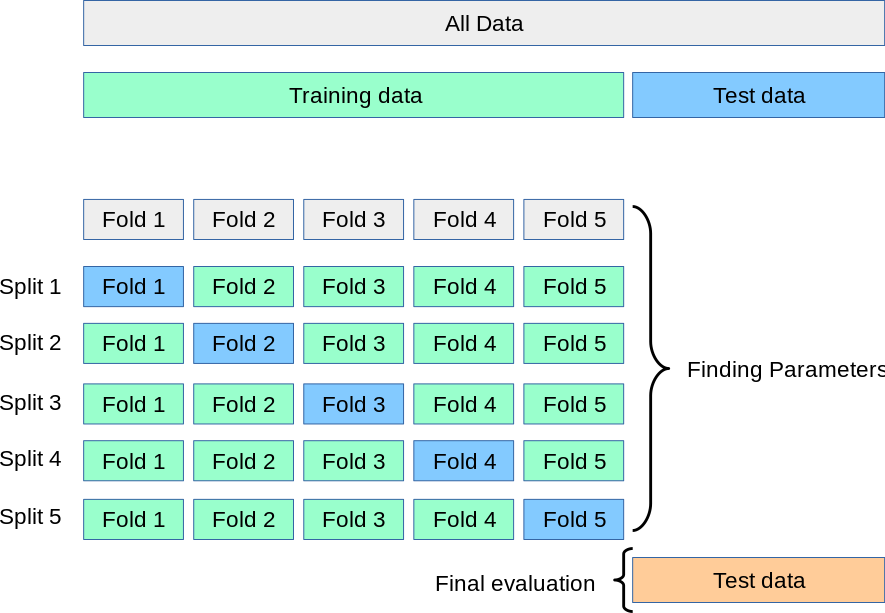

In [67]:
from sklearn.model_selection import cross_validate

pd.DataFrame(cross_validate(svr, X_train, y_train, cv=5, scoring='r2'))

,fit_time,score_time,test_score
0,1.096889,0.035356,0.719945
1,0.855191,0.031174,0.738408
2,0.978317,0.029761,0.730461
3,0.960773,0.030195,0.736996
4,0.860390,0.025346,0.709497


## Hyperparameter Searching

In [91]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'l1_ratio': [0, 0.15, 0.5, 0.85, 1],
}

X_scaled = StandardScaler().fit_transform(X_train)
reg = SGDRegressor()  # faster

grid = GridSearchCV(reg, param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_scaled, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1],
                         'l1_ratio': [0, 0.15, 0.5, 0.85, 1],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [90]:
vars(grid)

{'scoring': None,
 'estimator': SGDRegressor(),
 'n_jobs': -1,
 'refit': True,
 'cv': 5,
 'verbose': 1,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_grid': {'alpha': [0.001, 0.01, 0.1, 1],
  'penalty': ['l1', 'l2'],
  'l1_ratio': [0, 0.15, 0.5, 0.85, 1]},
 'multimetric_': False,
 'best_index_': 14,
 'best_score_': 0.603549426148849,
 'best_params_': {'alpha': 0.01, 'l1_ratio': 0.5, 'penalty': 'l1'},
 'best_estimator_': SGDRegressor(alpha=0.01, l1_ratio=0.5, penalty='l1'),
 'refit_time_': 0.033190250396728516,
 'scorer_': <function sklearn.metrics._scorer._passthrough_scorer(estimator, *args, **kwargs)>,
 'cv_results_': {'mean_fit_time': array([0.06046934, 0.03299432, 0.04963942, 0.06708231, 0.07557983,
         0.06305032, 0.06108294, 0.08176193, 0.08549714, 0.085255  ,
         0.13995104, 0.07537332, 0.07511387, 0.05547881, 0.10760789,
         0.09117484, 0.07499871, 0.06902771, 0.11274419, 0.04731898,
         0.09353456, 0.08115578, 0.067

In [93]:
grid.best_params_, grid.best_score_

({'alpha': 0.01, 'l1_ratio': 1, 'penalty': 'l1'}, 0.6034353084990545)

In [88]:
cv = grid.cv_results_
pd.DataFrame([cv['param_alpha'], cv['param_penalty'], cv['param_l1_ratio'], cv['mean_test_score']],
             index=['alpha', 'penalty', 'l1_ratio', 'mean_test_score']).T

,alpha,penalty,l1_ratio,mean_test_score
0,0.001,l1,0,-5323.274428
1,0.001,l2,0,-17363.619859
2,0.001,l1,0.15,-29800.889666
3,0.001,l2,0.15,-15221.962541
4,0.001,l1,0.5,-84089.664461
5,0.001,l2,0.5,-31748.920888
6,0.001,l1,0.85,-28174.59694
7,0.001,l2,0.85,-30044.86583
8,0.001,l1,1,-12434.484722
9,0.001,l2,1,-5883.982874


## Supplementary

About vars() and  \_\_dict__

In [104]:
def f(x, y):
    return vars()

class A:
    def __init__(self, x, y):
        self.x = x
        self.y = y

a = A(2, 1)

print(f(1, 2))
print(vars(a))
print(a.__dict__)

{'x': 1, 'y': 2}
{'x': 2, 'y': 1}
{'x': 2, 'y': 1}


In [106]:
# attributes can be updated by modifying __dict__
a.__dict__['x'] = 3
a.__dict__.update(y=2, z=1)
vars(a)

{'x': 3, 'y': 2, 'z': 1}